### Import Required Packages

In [153]:
import pandas as pd
import py_entitymatching as em
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from urllib2 import urlopen
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance, jaccard_distance
from IPython.display import Image  
import pydotplus
import warnings
warnings.filterwarnings('ignore')

# Import Datasets & Create Features
1. __"Golden Data"__
    1. Labeled dataset of 350 instances
2. __Spoj & Codechef tables__
    1. Contains scraped data (this is the data that we have processed in previous steps)
3. __Merge Spoj & Codechef to one table__
4. __Create features to train model__
    1. Exact title match
    2. Difference in description word length
    3. Jaccard similarity in title
    4. Edit distance in title

In [187]:
# Step 1: Golden Data
labeled_data = pd.read_csv("labeled_set.csv")
train_data, test_data = train_test_split(labeled_data, test_size=0.125, random_state=42)
train_data.head(5)

,ltable_problem_code,rtable_problem_code,Match (0 / 1)
46,NOVICE21,DETDET,0
321,ACMNSIT4,ASYA2,0
338,EASYMATC,BIGO02,0
70,HS10SQFT,SUM1,0
374,XMEDIAN,SNON06,0


In [188]:
# Step 2: Load Spoj & Codechef raw (preprocessed in previous steps) data
table_spoj = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/spoj/json/spoj_blocking.csv?token=AKuoLY5MivG2TZG4d-muAPxqyxMxTEILks5YOF8cwA%3D%3D"
table_A = pd.read_csv(urlopen(table_spoj)).drop("Unnamed: 0", axis=1)
table_A["words"] = table_A["description"].fillna("") + table_A["input"].fillna("") + table_A["output"].fillna("")
table_A = table_A.drop(["description", "input", "output"], axis=1)

table_codechef = "https://raw.githubusercontent.com/KaranTalreja/CS638/master/codechef/data/codechef_blocking.csv?token=AKuoLXwjsuxUcagsz8a-rKDmRJpIx82Wks5YOF80wA%3D%3D"
table_B = pd.read_csv(urlopen(table_codechef))
table_B["words"] = table_B["description"].fillna("") + table_B["input"].fillna("") + table_B["output"].fillna("")
table_B = table_B.drop(["description", "input", "output"], axis=1)

In [189]:
# Step 3: Merge Spoj & Codechef to one table

training = pd.DataFrame()

for i,j in train_data.iterrows():
    A_title, A_solve_rate_normalized, A_words = table_A[table_A["title"] == j["ltable_problem_code"]].drop("difficulty_normalized", axis=1).values[0]
    A_index = table_A[table_A["title"] == j["ltable_problem_code"]].drop("difficulty_normalized", axis=1).index.values[0]
    
    B_title, B_solve_rate_normalized, B_words = table_B[table_B["title"] == j["rtable_problem_code"]].drop("Unnamed: 0", axis=1).values[0]
    B_index = table_B[table_B["title"] == j["rtable_problem_code"]].drop("Unnamed: 0", axis=1).index.values[0]
    
    match = j["Match (0 / 1)"]
    
    training = training.append([{
                "index": i,
                "A_index": A_index,
                "A_title": A_title,
                "A_solve_rate_normalized": A_solve_rate_normalized,
                "A_words": A_words,
                "B_index": B_index,
                "B_title": B_title,
                "B_solve_rate_normalized": B_solve_rate_normalized,
                "B_words": B_words,
                "match": match,
            }])

training = training.set_index("index")

In [190]:
# Step 4: Create features to train model

def exact_match_title(df):
    if df["A_title"] == df["B_title"]:
        return 1
    else:
        return 0
    
def words_length(df):
    A_word_len = len(df["A_words"].split(" "))
    B_word_len = len(df["B_words"].split(" "))
    return abs(A_word_len - B_word_len)

def jaccard_similarity(x,y):
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def jaccard_A_B(df):
    A_word_len = df["A_words"].split(" ")
    B_word_len = df["B_words"].split(" ")
    return jaccard_similarity(A_word_len, B_word_len)

def title_edit_dist(df):
    A_title = df["A_title"]
    B_title = df["B_title"]
    return edit_distance(A_title, B_title)
    
training["exact_title_match"] = training.apply(exact_match_title, axis=1)
training["diff_in_words_len"] = training.apply(words_length, axis=1)
training["jaccard_sim"] = training.apply(jaccard_A_B, axis=1)
# training["jaccard_dist"] = training.apply(jaccard_A_B2, axis=1)
training["edit_dist"] = training.apply(title_edit_dist, axis=1)
training_features = training[["match","exact_title_match","diff_in_words_len","jaccard_sim", "edit_dist"]]

In [162]:
training_features.head()

,match,exact_title_match,diff_in_words_len,jaccard_sim,edit_dist
index,,,,,
46,0,0,86,0.131387,7
321,0,0,61,0.188235,6
338,0,0,8,0.116667,8
70,0,0,95,0.150538,7
374,0,0,28,0.371795,7


# Begin Building & Evaluating ML Models
1. __Split data into Training & Validation sets__
    1. Validation set is 15% of golden data
2. __Build and Evaluate ML models__
    1. Logistic Regression Classifier
    2. Support Vector Machine
    3. Decision Tree Classifier
    4. Random Forrest Classifier
    5. Naïve Bayes Classifier (Gaussian NB)
3. __Test fit of each model with 10-fold cross-validation__

### Split Training to X and y

In [163]:
X = training_features.reset_index().drop(["match","index"], axis=1)
y = training_features.match.reset_index().drop("index", axis=1)
X_train, X_validate, y_train, y_validate = train_test_split(X, y, 
                                                            test_size=0.15, random_state=33)

### Logistic Regression Classifier

In [164]:
# Train Model
log_model = LogisticRegression(penalty="l1", class_weight="balanced").fit(X_train, y_train)

# Use Model to Predict
log_pred = log_model.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, log_pred)
print confusion_matrix(y_validate, log_pred)
for attr in range(0,len(X_validate.columns.values)):
    print "Coefficient for %s: %.4f" % (X_validate.columns.values[attr],log_model.coef_[0][attr])

             precision    recall  f1-score   support

          0       1.00      0.95      0.98        44
          1       0.82      1.00      0.90         9

avg / total       0.97      0.96      0.96        53

[[42  2]
 [ 0  9]]
Coefficient for exact_title_match: 0.0000
Coefficient for diff_in_words_len: 0.0040
Coefficient for jaccard_sim: 17.5963
Coefficient for edit_dist: -0.5043


In [165]:
# Cross Validation of Model
k_fold = KFold(n_splits=10)
print "Mean F1-score: %.4f" % cross_val_score(log_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

Mean F1-score: 0.9108


### SVM Classifier

In [166]:
# Train Model
svm_model = SVC(kernel="linear", class_weight="balanced").fit(X_train, y_train)

# Use Model to Predict
svm_pred = svm_model.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, svm_pred)
print confusion_matrix(y_validate, svm_pred)
for attr in range(0,len(X_validate.columns.values)):
    print "Coefficient for %s: %.4f" % (X_validate.columns.values[attr],svm_model.coef_[0][attr])

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        44
          1       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        53

[[44  0]
 [ 0  9]]
Coefficient for exact_title_match: 0.0884
Coefficient for diff_in_words_len: 0.0027
Coefficient for jaccard_sim: 5.7392
Coefficient for edit_dist: -0.1113


In [167]:
# Cross Validation of Model
k_fold = KFold(n_splits=10)
print "Mean F1-score: %.4f" % cross_val_score(svm_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

Mean F1-score: 0.9447


### Decision Tree Classifier

In [177]:
# Train Model
DT_model = DecisionTreeClassifier(class_weight="balanced", random_state=23).fit(X_train, y_train)

# Use Model to Predict
DT_pred = DT_model.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, DT_pred)
print confusion_matrix(y_validate, DT_pred)   

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        44
          1       1.00      1.00      1.00         9

avg / total       1.00      1.00      1.00        53

[[44  0]
 [ 0  9]]


In [178]:
# Cross Validation of Model
k_fold = KFold(n_splits=10)
print "Mean F1-score: %.4f" % cross_val_score(DT_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

Mean F1-score: 0.9051


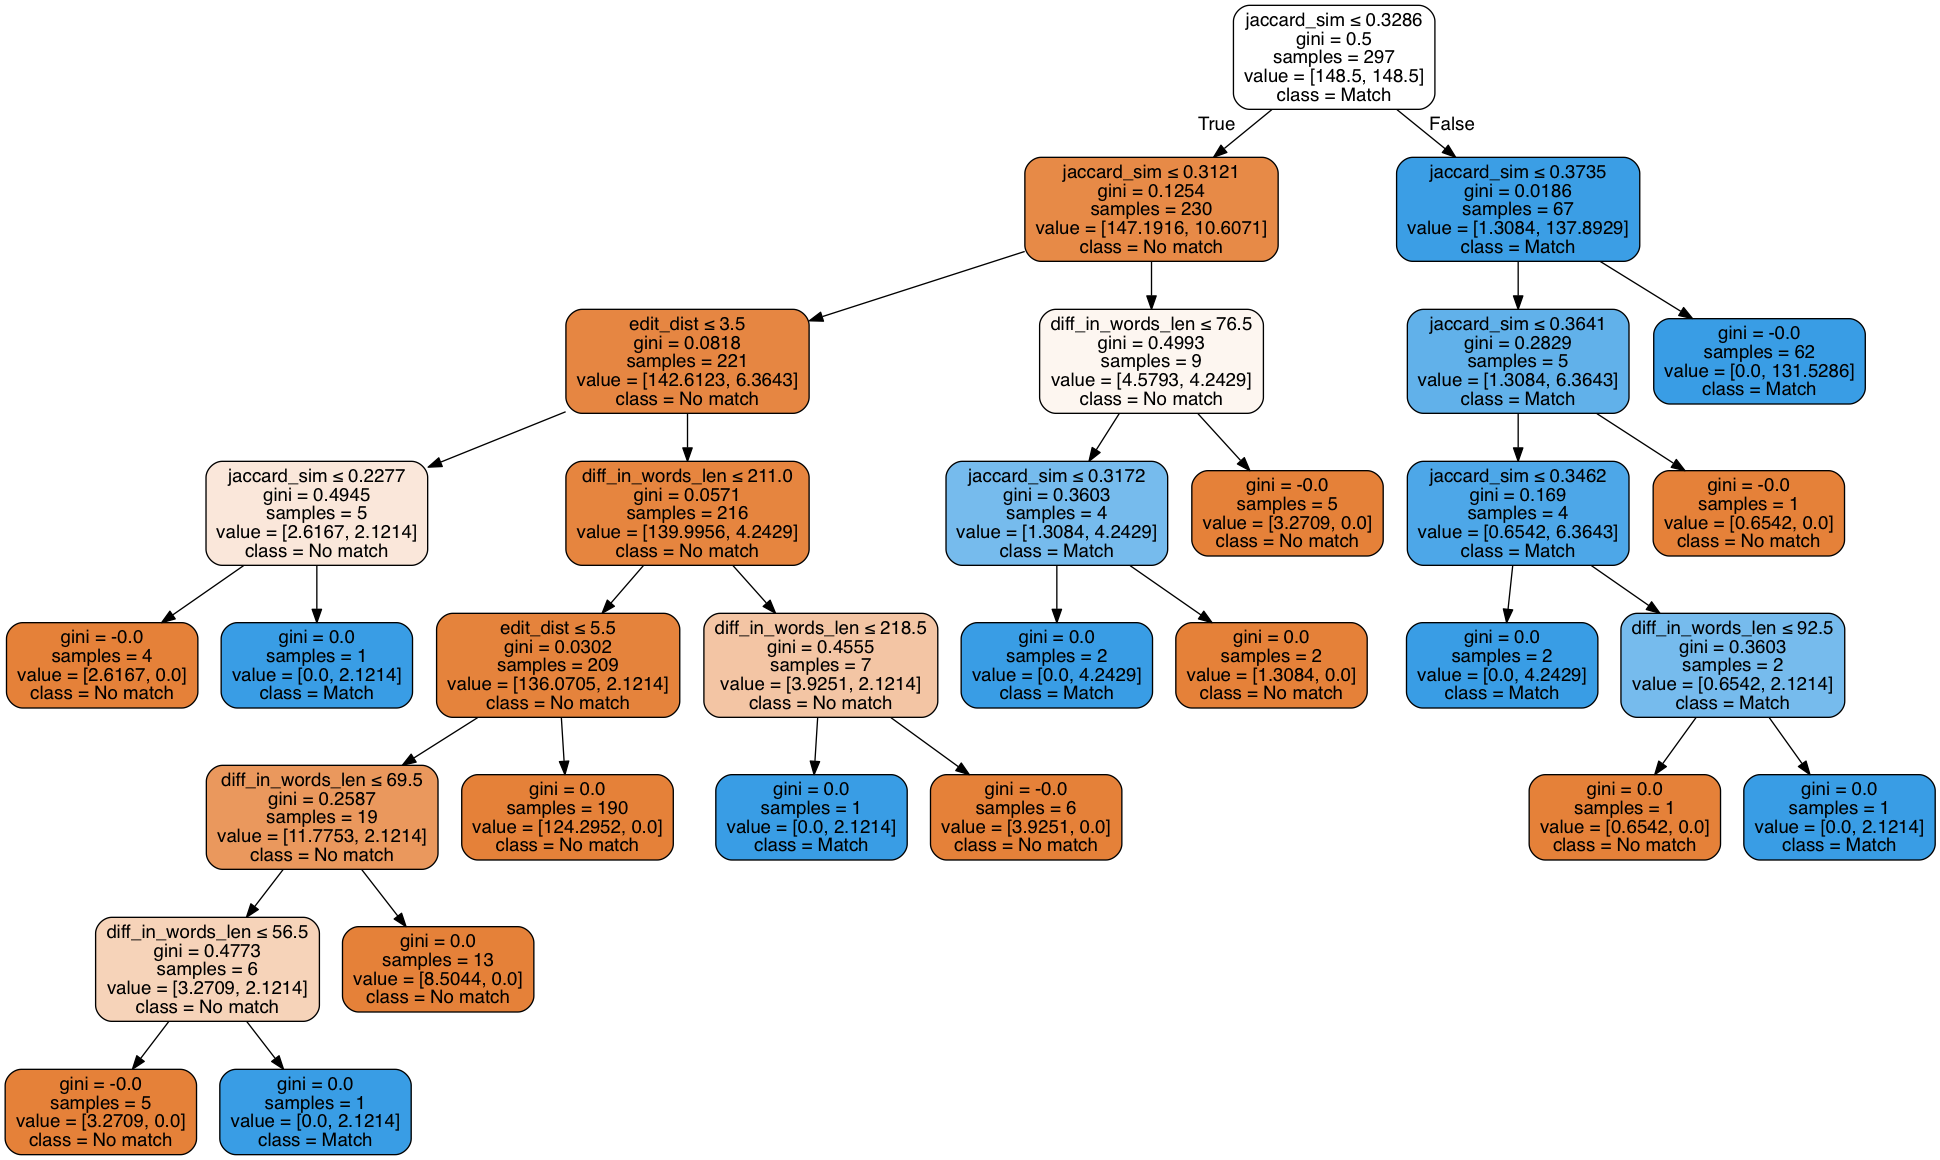

In [179]:
dot_data = export_graphviz(DT_model, out_file=None, 
                         feature_names=X_validate.columns.values,  
                         class_names=["No match", "Match"],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

### Random Forrest Classifier

In [182]:
# Train Model
RF_model = RandomForestClassifier(n_estimators=15, max_depth=5, random_state=44, 
                                  class_weight="balanced").fit(X_train, y_train)

# Use Model to Predict
RF_pred = RF_model.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, RF_pred)
print confusion_matrix(y_validate, RF_pred)

             precision    recall  f1-score   support

          0       1.00      0.98      0.99        44
          1       0.90      1.00      0.95         9

avg / total       0.98      0.98      0.98        53

[[43  1]
 [ 0  9]]


In [183]:
# Cross Validation of Model
k_fold = KFold(n_splits=10)
print "Mean F1-score: %.4f" % cross_val_score(RF_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

Mean F1-score: 0.9349


### Naïve Bayes Classifier

In [184]:
# Train Model
NB_model = GaussianNB().fit(X_train, y_train)

# Use Model to Predict
NB_pred = NB_model.predict(X_validate)

# Evaluate Model
print classification_report(y_validate, NB_pred)
print confusion_matrix(y_validate, NB_pred)   

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        44
          1       1.00      0.78      0.88         9

avg / total       0.96      0.96      0.96        53

[[44  0]
 [ 2  7]]


In [185]:
# Cross Validation of Model
k_fold = KFold(n_splits=10)
print "Mean F1-score: %.4f" % cross_val_score(NB_model, X, y, cv=k_fold, n_jobs=-1, scoring="f1").mean()

Mean F1-score: 0.9161
